# Machine Learning

### Importamos librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

### Leemos los datos

In [7]:
df = pd.read_csv('spotify_data.zip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159764 non-null  int64  
 1   artist_name       1159749 non-null  object 
 2   track_name        1159763 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null  float64
 9   key               1159764 non-null  int64  
 10  loudness          1159764 non-null  float64
 11  mode              1159764 non-null  int64  
 12  speechiness       1159764 non-null  float64
 13  acousticness      1159764 non-null  float64
 14  instrumentalness  1159764 non-null  float64
 15  liveness          1159764 non-null  float64
 16  

### Declaramos funciones útiles

In [8]:
def clean_outliers(df_aux, columns: list)->pd.DataFrame:
    """
    Función que elimina los valores atípicos de un dataframe en base a los cuartiles.
    
    Args: df_aux: DataFrame a limpiar.
        columns: Lista de columnas a limpiar.
    Returns: DataFrame sin valores atípicos
    """
    for column in columns:
        Q1 = df_aux[column].quantile(0.25)
        Q3 = df_aux[column].quantile(0.75)
        IQR = Q3 - Q1
        df_aux = df_aux[(df_aux[column] >= Q1-1.5*IQR) & (df_aux[column] <= Q3 + 1.5*IQR)]
    return df_aux

In [5]:
def normalize_data(df:pd.DataFrame, columns:list[str]):
    # restar la media y dividir entre la desviacion tipica
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df

### Regresion

#### Para un correcto funcionamiento, preprocesamos los datos de cara al machine learning

In [9]:
df = clean_outliers(df, ['loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'danceability', 'energy']) # Eliminamos los outliers
df["loudness"] = StandardScaler().fit_transform(df[["loudness"]]) # Escalamos la columna loudness para que no haya tanto rango entre las variables
df = normalize_data(df, ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence"]) # Normalizamos las columnas

In [9]:
df_aux = df[df["popularity"] >= 50] # Aplicamos un filtro para quedarnos sólo con las canciones populares, obteniendo un mejor aprendice para el modelo

#### División de datos

In [71]:
X, y = df_aux.drop(columns={"Unnamed: 0", "popularity", "artist_name", "track_name", "track_id", "genre", "duration_ms", "time_signature", "key", "mode", "tempo"}, axis=1), df_aux['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=15)

#### Entrenamos varios modelos

In [ ]:
epsilon = 100
max_iter = 500

model = HuberRegressor(epsilon=epsilon, max_iter=max_iter)
model.fit(X_train, y_train) 
mse_SVR = mse(y_test,model.predict(X_test))
print(mse_SVR)

In [66]:
#Librerías
from sklearn.ensemble import RandomForestRegressor
#Inicializamos modelo y parámetros
n_estimators = 200 #Estimadores del modelo
criterion = 'squared_error' #Forma de calcular el error
max_depth = None #Límite de profundidad de los árboles
min_samples_split = 2 #Criterio de parada de profundidad
verbose = 1 #Información devuelta por el método
#Instanciamos el modelo
model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, verbose=verbose)
#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_RF = mse(y_test,model.predict(X_test))
print(mse_RF)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   53.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


47.631559365748736


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


In [67]:
#Librerías
import xgboost as xgb
#Inicializamos modelo y parámetros
params = {"booster":"gbtree", "max_depth": 2, "eta": 0.3, "objective": "reg:squarederror", "nthread":2}
num_boost_round = 10
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)
#Instanciamos el modelo, entrenamos y elaboramos predicciones
model = xgb.train(params = params, dtrain = train_data, num_boost_round=num_boost_round)
mse_XGB = mse(y_test,model.predict(test_data))
print(mse_XGB)

46.79619859919413


In [68]:
#Librerías
from sklearn import svm
#Inicializamos modelo y parámetros
C = 1 #Parámetro regularizador
kernel = 'rbf' #Núcleo transformador
#Instanciamos el modelo
model = svm.SVR(C = C, kernel = kernel)
#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_SVR = mse(y_test,model.predict(X_test))
print(mse_SVR)

51.059615593146546


#### Comparamos los resultados

Text(0.5, 0, 'Modelo')

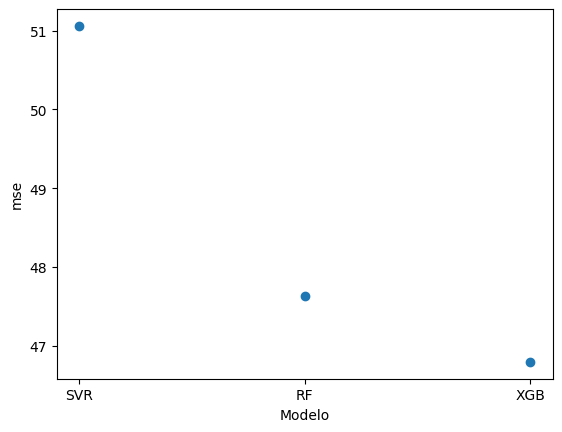

In [69]:
mse = [mse_SVR, mse_RF, mse_XGB]
plt.scatter(['SVR', 'RF', 'XGB'], mse)
plt.ylabel('mse')
plt.xlabel('Modelo')

#### Conclusión:
##### Pese a que con el filtro de popularidad > 50 hemos conseguido bajar el MSE de 250 a 47 aproximadamente, no parece que sea lo suficientemente preciso como para sernos útil.

### Clasificacion

In [10]:
from sklearn.metrics import classification_report

#### Creamos dos funciones para categorizar la variable objetivo

##### La primera la categoriza en tres intervalos diferentes

In [49]:
def popularity1(x):
    if 25 > x >= 0 :
        return "Baja popularidad"
    elif 55 > x >= 25:
        return "Popularidad media"
    else:
        return "Alta popularidad" 

##### La segunda la categoriza en sólo dos intervalos

In [11]:
def popularity2(x):
    if 50 > x >= 0 :
        return "Baja popularidad"
    else:
        return "Alta popularidad"

#### Al hacer pruebas, observamos que al categorizarla en dos intervalos incrementa considerablemente su precisión

In [12]:
df["popularity_target"] = df["popularity"].apply(lambda x: popularity2(x))

#### Para aumentar aún más su precisión, cogemos una muestra con la misma cantidad de valores por categoría

In [13]:
df["popularity_target"].value_counts()

popularity_target
Baja popularidad    849109
Alta popularidad     41044
Name: count, dtype: int64

In [86]:
df_aux = df[df["popularity_target"] == "Baja popularidad"].sample(41000, random_state=42)
df_aux2 = df[df["popularity_target"] == "Alta popularidad"].sample(41000, random_state=42)

In [87]:
df_aux = pd.concat([df_aux, df_aux2])

#### Preparamos los datos dropeando columnas y redondeando las cifras para una mejor gestión de predicciones en la app

In [91]:
df_aux = df_aux.drop(columns={"Unnamed: 0", "popularity", "artist_name", "track_name", "track_id", "genre", "duration_ms", "time_signature", "key", "mode", "liveness", "year"}, axis=1)

In [92]:
for i in df_aux.columns:
    if i != "popularity_target":
        df_aux[i] = df_aux[i].map(lambda x: np.round(x, 2)) # Aplicamos una función sencilla, al no poder aplicar un redondeo a un string recorremos cada columna del dataframe

In [93]:
df_aux

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,popularity_target
751506,0.62,0.90,-3.81,0.04,0.05,0.00,0.75,153.10,Baja popularidad
1143104,0.58,0.50,-10.24,0.03,0.61,0.42,0.29,83.95,Baja popularidad
735799,0.42,0.75,-4.88,0.04,0.00,0.45,0.07,118.80,Baja popularidad
1144395,0.55,0.94,-3.76,0.12,0.00,0.01,0.53,94.91,Baja popularidad
131657,0.32,0.58,-7.45,0.04,0.11,0.00,0.50,72.63,Baja popularidad
...,...,...,...,...,...,...,...,...,...
74568,0.74,0.72,-6.48,0.06,0.72,0.00,0.97,126.08,Alta popularidad
542346,0.68,0.71,-10.76,0.04,0.02,0.03,0.05,124.01,Alta popularidad
837948,0.76,0.66,-6.60,0.04,0.03,0.01,0.55,132.02,Alta popularidad
390200,0.65,0.80,-5.70,0.16,0.45,0.00,0.32,153.01,Alta popularidad


#### Dividimos los datos

In [94]:
X, y = df_aux.drop(columns={"popularity_target"}, axis=1), df_aux['popularity_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=15)

#### Entrenamos el modelo

In [56]:
from sklearn.linear_model import LogisticRegression
# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(max_iter =100)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\NITROPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                  precision    recall  f1-score   support

Alta popularidad       0.66      0.75      0.70      8205
Baja popularidad       0.71      0.62      0.66      8195

        accuracy                           0.68     16400
       macro avg       0.68      0.68      0.68     16400
    weighted avg       0.68      0.68      0.68     16400



In [42]:
from sklearn.neighbors import KNeighborsClassifier
#Parámetros
weights = 'distance'
p = 2
n_neighbours = 10
#Modelo
clf = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

Alta popularidad       0.62      0.72      0.67      8205
Baja popularidad       0.67      0.55      0.60      8195

        accuracy                           0.64     16400
       macro avg       0.64      0.64      0.63     16400
    weighted avg       0.64      0.64      0.63     16400



In [43]:
from sklearn.naive_bayes import GaussianNB
#Tratamos datos como pd.DataFrame
#Modelo
nbmodelo = GaussianNB()

nbmodelo.fit(X_train, y_train)
y_pred = nbmodelo.predict(X_test)

print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

Alta popularidad       0.60      0.84      0.70      8205
Baja popularidad       0.74      0.45      0.56      8195

        accuracy                           0.65     16400
       macro avg       0.67      0.65      0.63     16400
    weighted avg       0.67      0.65      0.63     16400



In [44]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_preds = RFC.predict(X_test)
print(classification_report(y_test, y_preds))

                  precision    recall  f1-score   support

Alta popularidad       0.68      0.72      0.70      8205
Baja popularidad       0.70      0.66      0.68      8195

        accuracy                           0.69     16400
       macro avg       0.69      0.69      0.69     16400
    weighted avg       0.69      0.69      0.69     16400



In [140]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=357, validation_fraction=0.1,n_iter_no_change=5, tol=0.01)
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test) #comentario prueba
print(classification_report(y_test, y_pred, zero_division=0))

                  precision    recall  f1-score   support

Alta popularidad       0.67      0.75      0.71      8205
Baja popularidad       0.71      0.62      0.67      8195

        accuracy                           0.69     16400
       macro avg       0.69      0.69      0.69     16400
    weighted avg       0.69      0.69      0.69     16400



#### Conclusión

##### Los modelos de clasificación hacen un mejor trabajo que los de regresión, llegando hasta un 0.69 de accuracy. Los datos ya están preparados para llevarlos a azure y entrenar los modelos en la nube, pudiendo ver así mucho más rápidamente qué modelo es el más óptimo

In [ ]:
# df_aux.to_csv('spotify_data_machine_learning.csv', index=False)